In [44]:
import os
import cv2
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from skimage.io import imread
from glob import glob

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layers
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


num_classes = 6
im_height = 256
im_width = 256

In [10]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters * 1, kernel_size=3,
                      batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout * 0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3,
                      batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3,
                      batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3,
                      batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3,
                      batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2),
                         padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3,
                      batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2),
                         padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3,
                      batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2),
                         padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3,
                      batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2),
                         padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3,
                      batchnorm=batchnorm)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


input_img = Input(shape=(im_height, im_width, 3), name="img")
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(),loss="categorical_crossentropy",metrics=["acc"])

In [11]:
model.load_weights('../models/unet-model-100.h5')

In [69]:
files = glob('../png'+'/**'+'/*.png')
img1 = np.array(imread(files[4]))
img1 = np.reshape(img1,(1,256,256,3))
r1 = model.predict(img1)
r1 = np.reshape(r1,(256,256,6))
r1[r1>=.5]=1
r1[r1<.5]=0
img2 = np.array(imread(files[10]))
img2 = np.reshape(img2,(1,256,256,3))
r2 = model.predict(img2)
r2 = np.reshape(r2,(256,256,6))
r2[r2>=.5]=1
r2[r2<.5]=0
d = np.linalg.norm(r1-r2,axis=2)

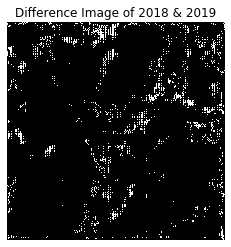

In [70]:
plt.imshow(d,cmap='gray')
plt.axis('off')
plt.title('Difference Image of 2018 & 2019')
plt.show()

In [71]:
K = 2
attempts=10
v = d.reshape((256**2,1))
v = np.float32(v)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(v,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
rimg = res.reshape((d.shape))

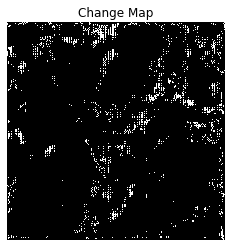

In [72]:
plt.imshow(rimg,cmap='gray')
plt.axis('off')
plt.title('Change Map')
plt.show()